# ACCRE Project - Data Import and Cleaning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

In [2]:
# Read in fullsample.csv as a dataframe
jobs = pd.read_csv("../data/fullsample.csv")

In [3]:
# Convert BEGIN and END columns to datetime type
jobs['BEGIN'] = pd.to_datetime(jobs['BEGIN'], errors='coerce')
jobs['END'] = pd.to_datetime(jobs['END'], errors='coerce')

# Drop all columns with null type in BEGIN or END columns
jobs = jobs.dropna(subset=['BEGIN', 'END'])

# Calculate length of jobs and assign in new column JOBLENGTH
jobs['JOBLENGTH'] = jobs['END'] - jobs['BEGIN']

# Convert REQTIME and USEDTIME columns to timedelta type
jobs['REQTIME'] = pd.to_timedelta(jobs['REQTIME'])
jobs['USEDTIME'] = pd.to_timedelta(jobs['USEDTIME'])

# Convert REQMEM column to total memory required and total memory
#for index in jobs.index:
 
    #if 
#jobs['REQMEMTOT'] = (required memory(per node or core))*(nodes or cores)
#jobs['REQMEMPERCORE'] = REQMEMTOT/CPUS

Data goes from October 1, 2020 to October 7, 2021.

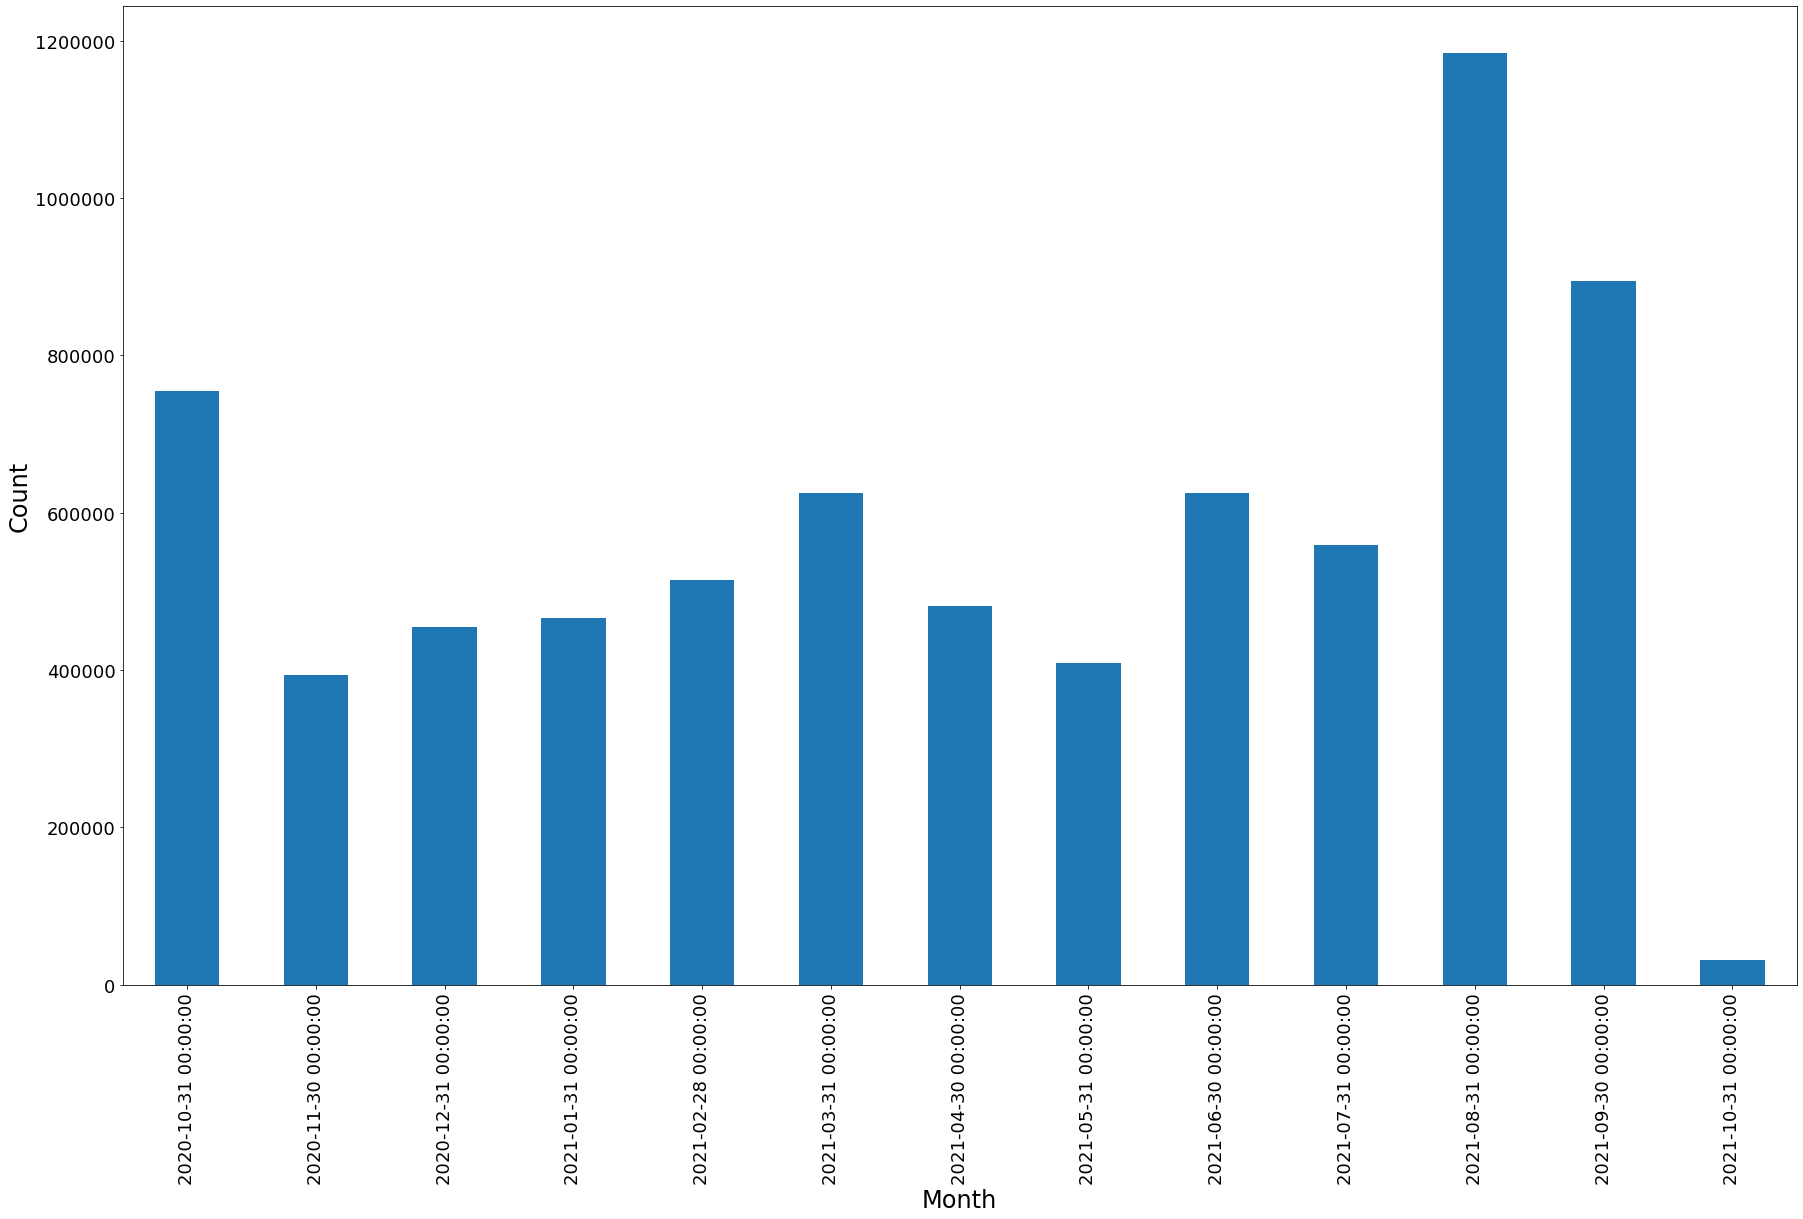

In [4]:
fig, ax = plt.subplots(figsize=(30,18))
jobs.groupby(pd.Grouper(key='END',freq='M')).count()['JOBID'].plot(kind='bar')
plt.xlabel('Month', fontsize=24)
plt.ylabel('Count', fontsize=24);
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.get_yaxis().get_major_formatter().set_scientific(False)

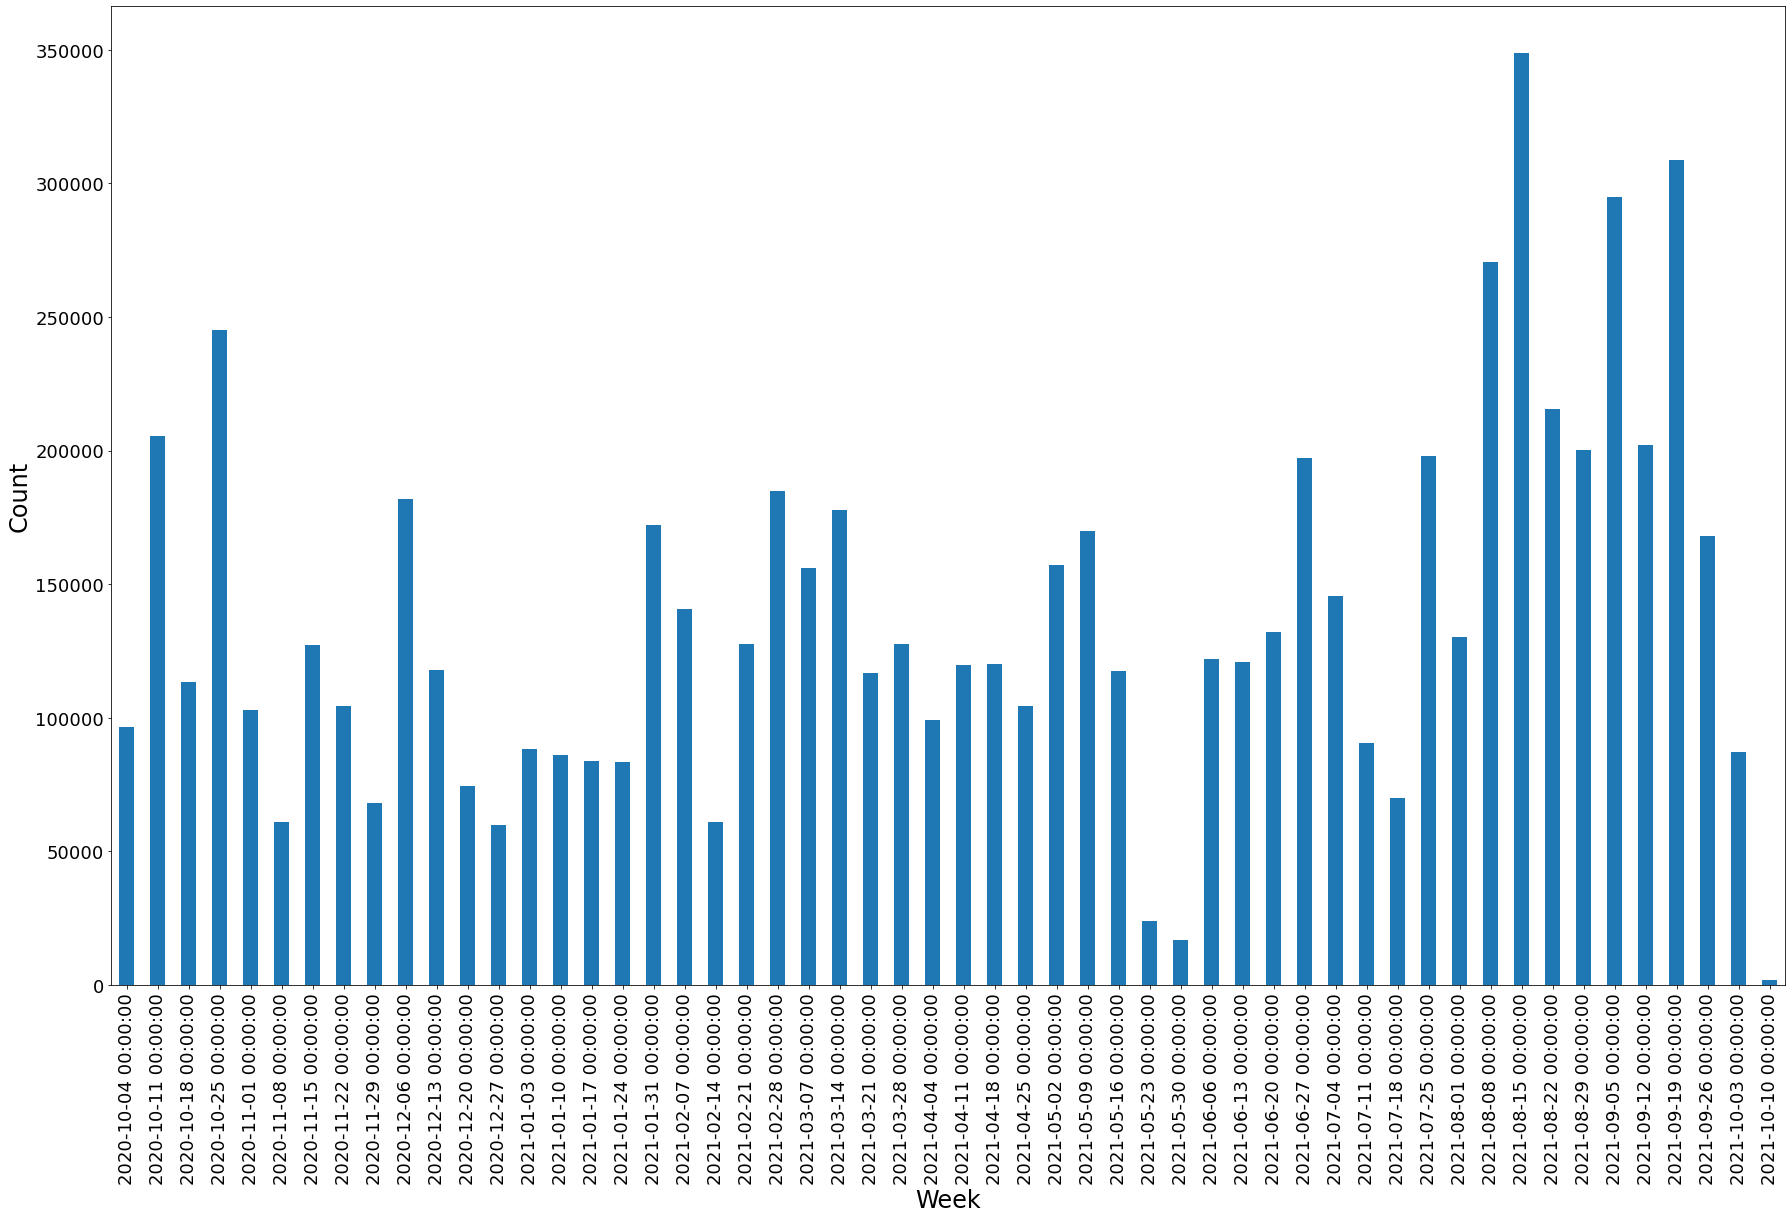

In [5]:
fig, ax = plt.subplots(figsize=(30,18))
jobs.groupby(pd.Grouper(key='END',freq='W')).count()['JOBID'].plot(kind='bar')
plt.xlabel('Week', fontsize=24)
plt.ylabel('Count', fontsize=24);
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.get_yaxis().get_major_formatter().set_scientific(False)

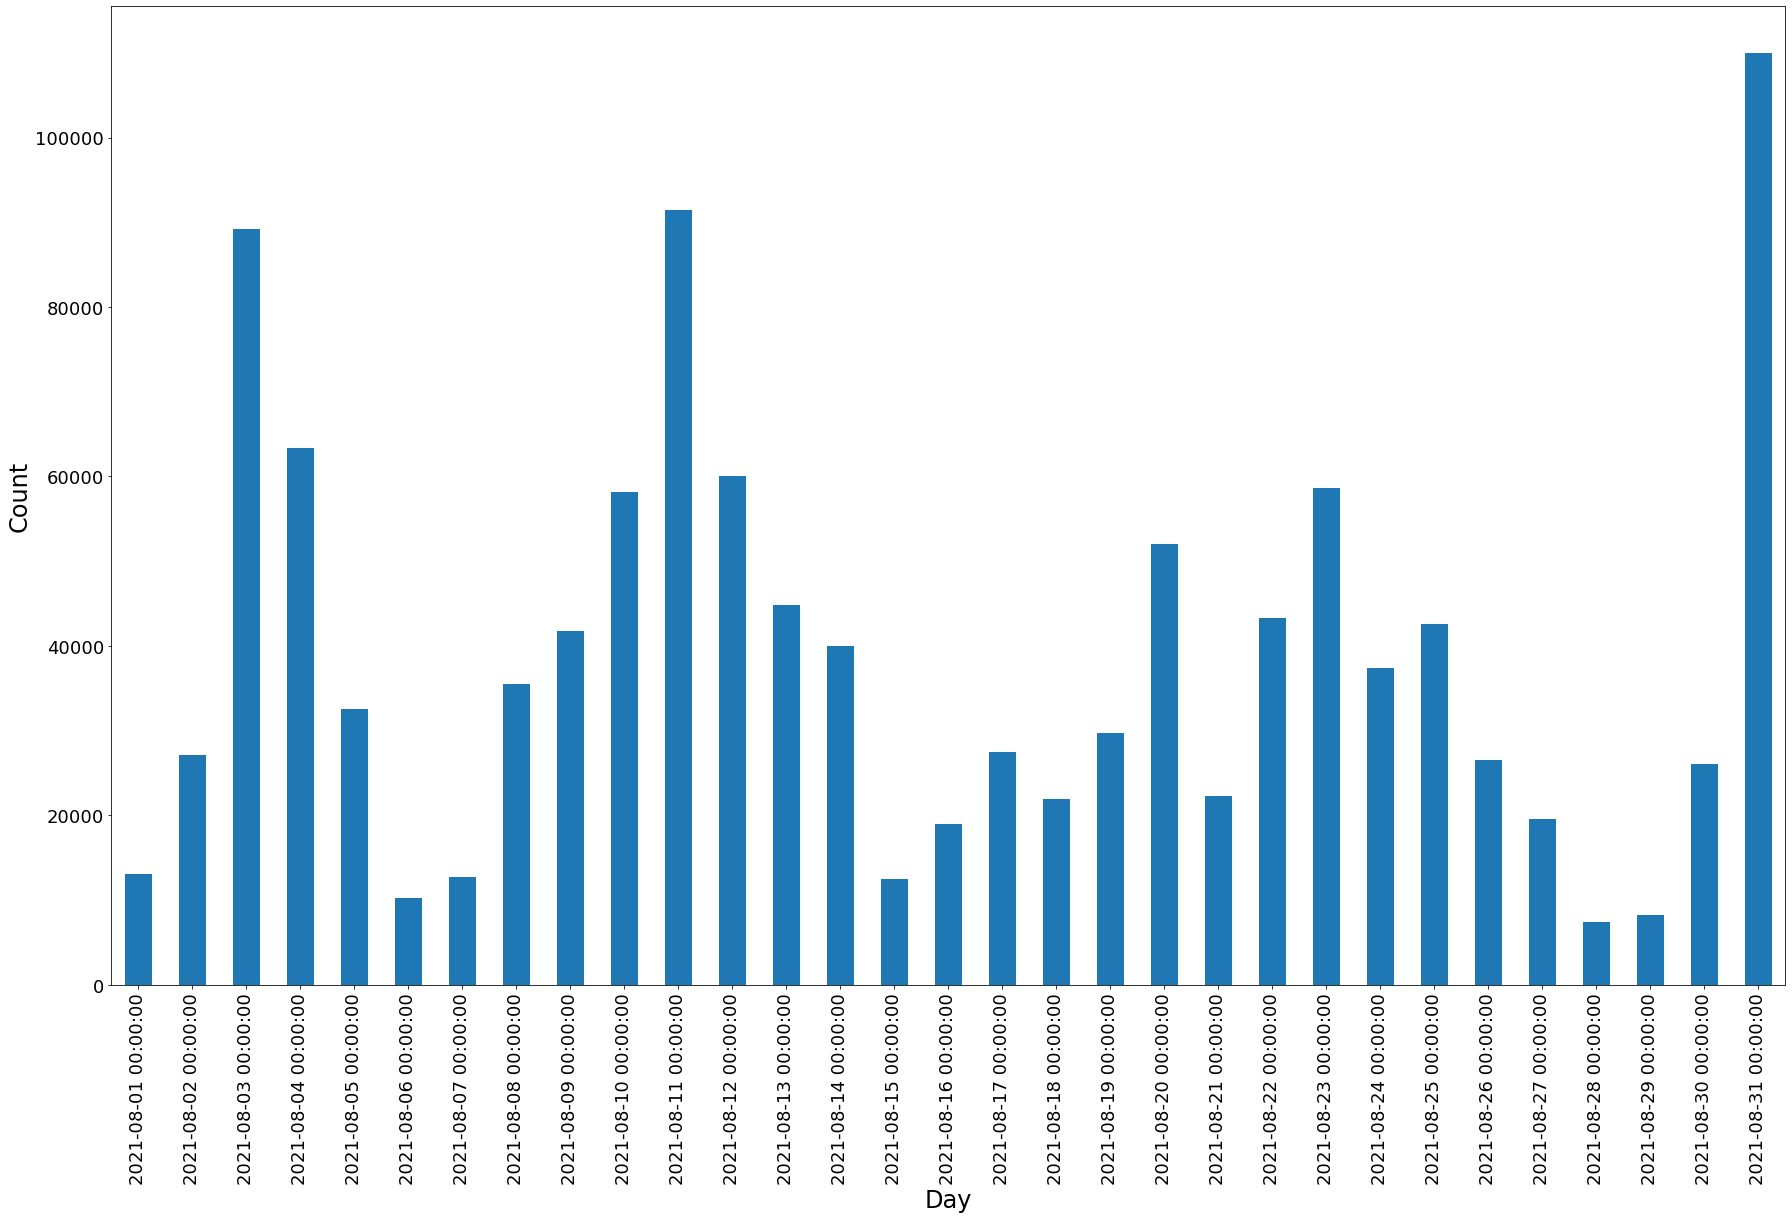

In [7]:
fig, ax = plt.subplots(figsize=(30,18))
jobs[(pd.to_datetime('2021-07-31') < jobs['END'].dt.date) & (jobs['END'].dt.date < pd.to_datetime('2021-09-01'))].groupby(pd.Grouper(key='END',freq='D')).count()['JOBID'].plot(kind='bar')
plt.xlabel('Day', fontsize=24)
plt.ylabel('Count', fontsize=24);
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.get_yaxis().get_major_formatter().set_scientific(False)

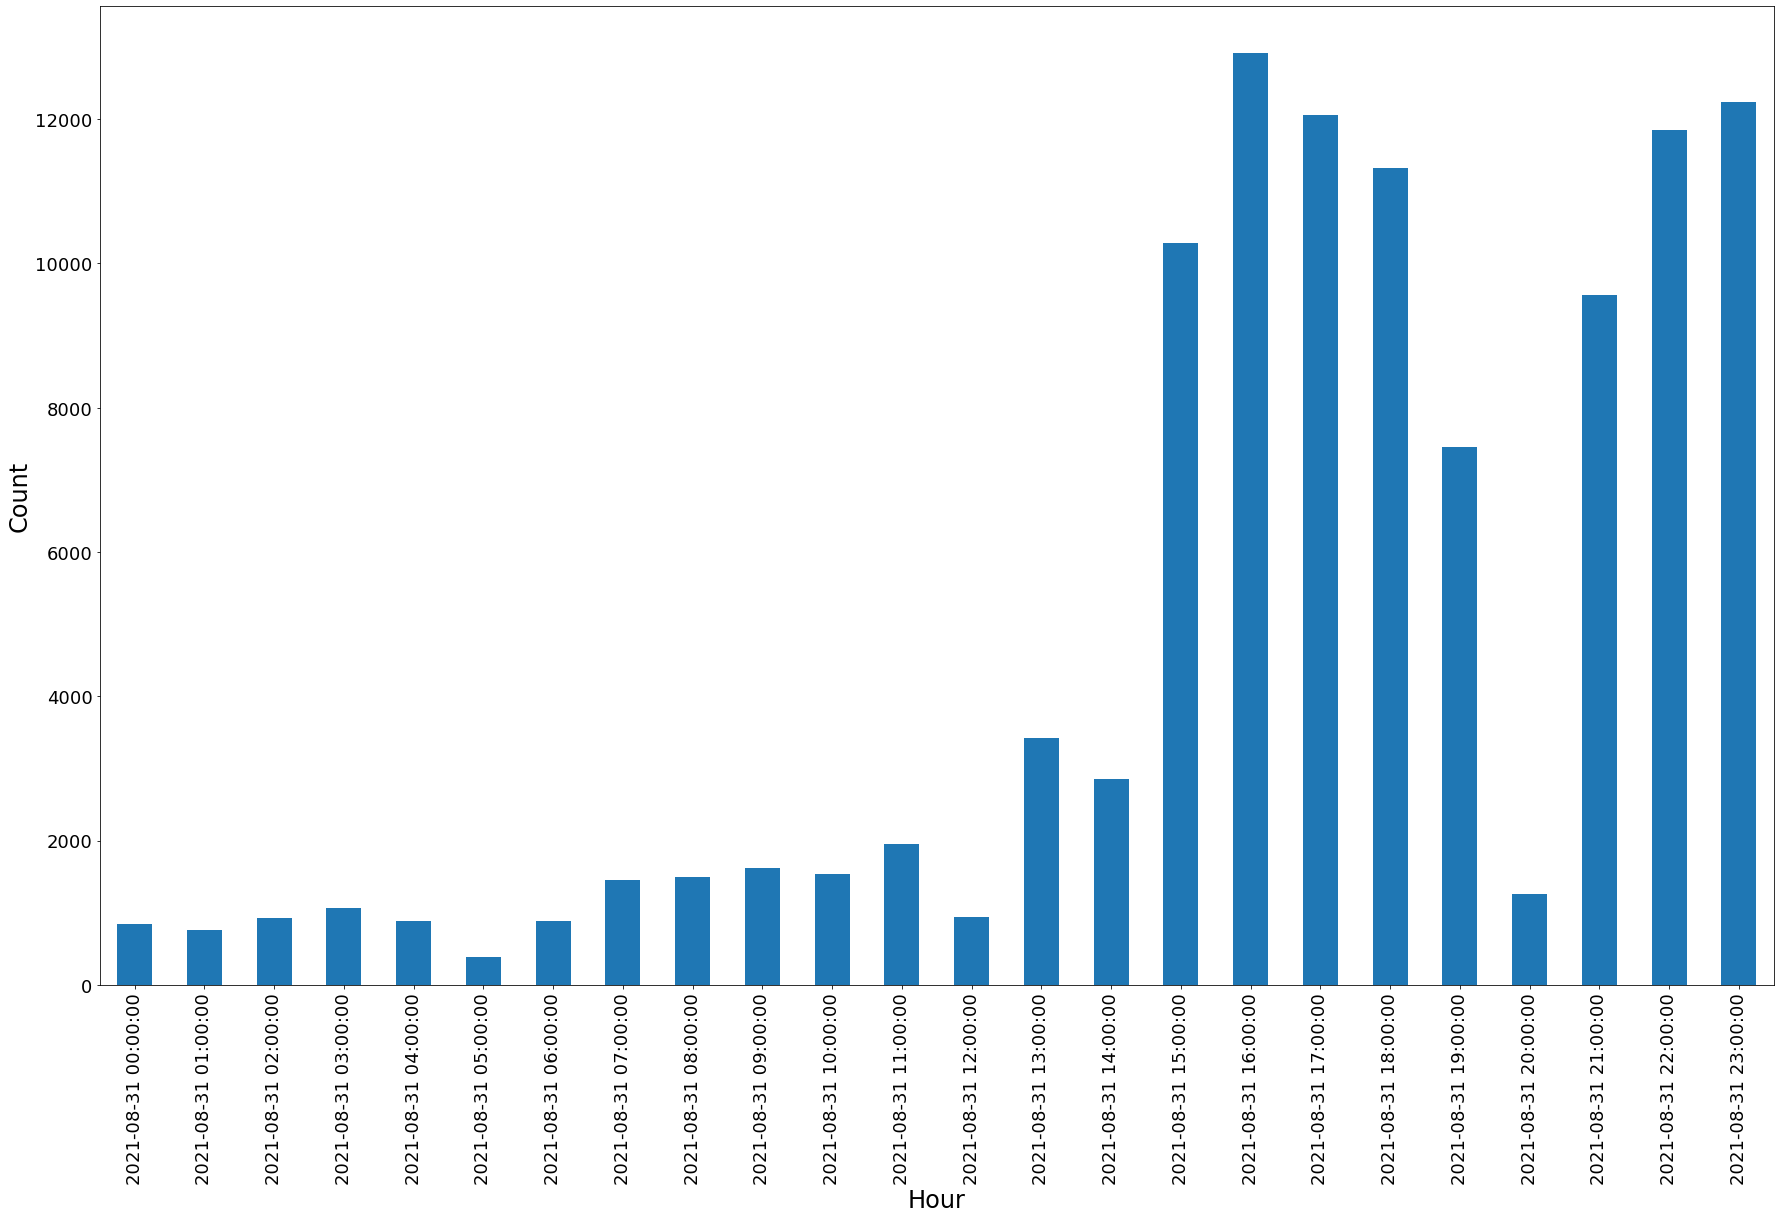

In [8]:
fig, ax = plt.subplots(figsize=(30,18))
jobs[jobs['END'].dt.date == pd.to_datetime('2021-08-31')].groupby(pd.Grouper(key='END',freq='H')).count()['JOBID'].plot(kind='bar')
plt.xlabel('Hour', fontsize=24)
plt.ylabel('Count', fontsize=24);
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.get_yaxis().get_major_formatter().set_scientific(False)